In [1]:
import cv2
from glob import glob
import numpy as np
from PIL import Image, ImageOps
from tqdm import tqdm
from tqdm.notebook import tqdm

import tensorflow as tf
import PIL.ImageOps

from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Add
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))
    
    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

def slicer(images, names, segment=80, timeAxis=False):
    half = segment // 4
    retImg = []
    retClass = []
    
    for img, name in zip(images, names):
        if timeAxis:
            timeImage = []

        for i in range(0, img.shape[1], half):
            if i + half * 3 > img.shape[1]:
                continue
            
            tmp = img[:, i:i + segment]
            tmp = np.pad(tmp, ((0, 0), (0, segment - tmp.shape[1])), 'constant', constant_values=0)

            if timeAxis:
                timeImage.append(tmp)
            else:
                retImg.append(tmp)
                retClass.append(name)

        if timeAxis and len(timeImage) > 0:   # Check if timeImage has content
            retImg.append(np.stack(timeImage))
            retClass.append(name)

    return retImg, retClass


# Load data
def loadData(perClassData=None, h=80):
    '''
    Give the directory of dataset in the glob function
    Generate target name/identity in name variable
    '''
    imgFiles = glob("./data/temp_sentences/*.png")
    print(len(imgFiles), 'images found.')

    ImageArray = []
    Names = []

    for imgFile in tqdm(imgFiles):  # <-- This line was corrected
        fileName = (imgFile.split('/')[-1]).split('.')[0]
        name = fileName.split('-')[0]                           # Target Class

        img = Image.open(imgFile)
        img = PIL.ImageOps.invert(img)
        image = image_resize(np.array(img, dtype=np.uint8), height=h)
        
        if image.ndim > 2:
            continue

        image = image / 255
        ImageArray.append(image)
        Names.append(name)
    
    print('Total Unique Classes', len(np.unique(Names)))
    return ImageArray, Names  


In [3]:
X, y = loadData(60, h=113)

4909 images found.


  0%|          | 0/4909 [00:00<?, ?it/s]

Total Unique Classes 25


X is the black and white word image of shape (row, cols, 1).

row and col doesn't have to be same.

y is the target class.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state=40)

# XX_test, yy_test is the multiple (113, 113) segmented images of word line
XX_test, yy_test = slicer(X_test, y_test, segment=113, timeAxis=True)

# Set timeAxis=False for a lower dimention

In [5]:
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder().fit(np.array(y).reshape(-1, 1))

y_train = np.array(y_train)
y_test = np.array(y_test)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_train_OHE = OHE.fit_transform(y_train).toarray()
y_test_OHE = OHE.transform(y_test).toarray()

In [6]:
def deepWriter(input_shape, classes):
    # Two different input patches
    patch_1 = Input(shape=input_shape)
    patch_2 = Input(shape=input_shape)

    # Convolution_1 shares the same weight
    conv1 = Conv2D(96, kernel_size=5, strides=2, activation='relu')
    out1 = conv1(patch_1)
    out2 = conv1(patch_2)

    # MaxPooling
    MP = MaxPooling2D(3, strides=2)
    out1 = MP(out1)
    out2 = MP(out2)

    # Convolution_2 shares the same weight
    conv2 = Conv2D(256, kernel_size=3, activation='relu')
    out1 = conv2(out1)
    out2 = conv2(out2)

    # MaxPooling
    out1 = MP(out1)
    out2 = MP(out2)

    # Convolution_3 shares the same weight
    conv3 = Conv2D(384, kernel_size=3, activation='relu')
    out1 = conv3(out1)
    out2 = conv3(out2)

    # Convolution_4 shares the same weight
    conv4 = Conv2D(384, kernel_size=3, activation='relu')
    out1 = conv4(out1)
    out2 = conv4(out2)

    # Convolution_5 shares the same weight
    conv5 = Conv2D(256, kernel_size=3, activation='relu')
    out1 = conv5(out1)
    out2 = conv5(out2)

    # MaxPooling
    out1 = MP(out1)
    out2 = MP(out2)

    # Flatten
    flat = Flatten()
    out1 = flat(out1)
    out2 = flat(out2)

    # Fully Connected Layer (FC6)
    FC6 = Dense(1024)
    out1 = FC6(out1)
    out2 = FC6(out2)

    # Dropout of 0.5
    out1 = Dropout(0.5)(out1)
    out2 = Dropout(0.5)(out2)

    # Fully Conneted Layer (FC7)
    FC7 = Dense(1024)
    out1 = FC7(out1)
    out2 = FC7(out2)

    # Dropout of 0.5
    out1 = Dropout(0.5)(out1)
    out2 = Dropout(0.5)(out2)

    # Summation of two outputs
    out = Add()([out1, out2])

    # Softmax layer
    out = Dense(classes, activation='softmax')(out)

    # Make model and compile
    model = Model(inputs=[patch_1, patch_2], outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['acc'])

    return model


def halfDeepWriter(input_shape, classes, frac=1):
    patch_1 = Input(shape=input_shape)

    out1 = Conv2D(int(96*frac), kernel_size=5, strides=2, activation='relu')(patch_1)
    out1 = MaxPooling2D(3, strides=2)(out1)

    out1 = Conv2D(int(256*frac), kernel_size=3, activation='relu')(out1)
    out1 = MaxPooling2D(3, strides=2)(out1)

    out1 = Conv2D(int(384*frac), kernel_size=3, activation='relu')(out1)
    out1 = Conv2D(int(384*frac), kernel_size=3, activation='relu')(out1)
    out1 = Conv2D(int(256*frac), kernel_size=3, activation='relu')(out1)
    out1 = MaxPooling2D(3, strides=2)(out1)

    out1 = Flatten()(out1)
    out1 = Dense(int(1024*frac), activation='relu')(out1)
    out1 = Dropout(0.5)(out1)

    out1 = Dense(int(1024*frac), activation='relu')(out1)
    out1 = Dropout(0.5)(out1)

    out1 = Dense(classes, activation='softmax')(out1)

    model = Model(inputs=patch_1, outputs=out1)
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['acc'])

    return model

In [7]:
import tensorflow
# Random image strip image generator of DeepWriter's image stripping strategy

class dataGeneratorDeepWriter(tensorflow.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32, shuffle=True, w=80):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.inputX = X
        self.inputY = y
        self.w = w
        self.h = self.inputX[0].shape[0]
        self.total = len(X)
        self.indexes = np.arange(self.total)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.total / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batchIndexes):
        'Generates data containing batch_size samples' # X : (2, n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size, 2, self.h, self.w))
        y = np.empty((self.batch_size, self.inputY.shape[-1]), dtype=int)
        
        # Generate data
        for i, ID in enumerate(batchIndexes):
            # Black Image
            tmpImg = np.zeros((self.h, self.w))
            
            # Starting column position
            y_pos1, y_pos2 = map(int, (np.random.randint(low=0, 
                        high=max(self.inputX[ID].shape[1]-self.w//3, 1),
                        size=2)))
            
            # Placing Image in black image
            tmpImg1 = (self.inputX[ID])[:, y_pos1:y_pos1+self.w]
            tmpImg2 = (self.inputX[ID])[:, y_pos2:y_pos2+self.w]

            # Placing Image in output
            X[i, 0, 0:tmpImg1.shape[0], 0:tmpImg1.shape[1]] = tmpImg1
            X[i, 1, 0:tmpImg2.shape[0], 0:tmpImg2.shape[1]] = tmpImg2
            
            # Store class
            y[i] = self.inputY[ID]

        X = X[:, :, :, :, np.newaxis]
        return [X[:, 0, :, :], X[:, 1, :, :]], y


class dataGeneratorHalfDeepWriter(tensorflow.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32, shuffle=True, w=80):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.inputX = X
        self.inputY = y
        self.w = w
        self.h = self.inputX[0].shape[0]
        self.total = len(X)
        self.indexes = np.arange(self.total)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.total / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batchIndexes):
        'Generates data containing batch_size samples' # X : (2, n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size, self.h, self.w))
        y = np.empty((self.batch_size, self.inputY.shape[-1]), dtype=int)
        
        # Generate data
        for i, ID in enumerate(batchIndexes):
            # Black Image
            tmpImg = np.zeros((self.h, self.w))
            
            # Starting column position
            y_pos1 = int(np.random.randint(low=0, 
                        high=max(self.inputX[ID].shape[1]-self.w//3, 1),
                        size=1))
            
            # Placing Image in black image
            tmpImg1 = (self.inputX[ID])[:, y_pos1:y_pos1+self.w]

            # Placing Image in output
            X[i, 0:tmpImg1.shape[0], 0:tmpImg1.shape[1]] = tmpImg1
            
            # Store class
            y[i] = self.inputY[ID]

        X = X[:, :, :, np.newaxis]
        return X, y


In [10]:
model = halfDeepWriter((113, 113, 1), 25, )
model.summary()
#model.load_weights('/content/best.hdf5')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 113, 113, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        2496      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 27, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 25, 25, 256)       221440    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 384)       8851

In [11]:
train_gen = dataGeneratorHalfDeepWriter(X_train, y_train_OHE, batch_size=128, w=113)
test_gen = dataGeneratorHalfDeepWriter(X_test, y_test_OHE, batch_size=128, w=113)

hist = model.fit(train_gen, validation_data=test_gen, epochs=50, 
                 callbacks=[ ModelCheckpoint(filepath='/content/best.hdf5',
                             save_best_only=True, monitor='acc', mode='max',
                            ), ])

Epoch 1/50
30/30 [==============================] - 31s 984ms/step - loss: 3.2083 - acc: 0.2148 - val_loss: 2.5777 - val_acc: 0.3047
Epoch 2/50


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 30s 984ms/step - loss: 2.5127 - acc: 0.3250 - val_loss: 2.5169 - val_acc: 0.3058
Epoch 3/50
30/30 [==============================] - 30s 1s/step - loss: 2.4821 - acc: 0.3250 - val_loss: 2.5034 - val_acc: 0.3125
Epoch 4/50
30/30 [==============================] - 29s 975ms/step - loss: 2.4818 - acc: 0.3242 - val_loss: 2.5443 - val_acc: 0.3025
Epoch 5/50
30/30 [==============================] - 29s 962ms/step - loss: 2.4665 - acc: 0.3273 - val_loss: 2.5175 - val_acc: 0.3036
Epoch 6/50
30/30 [==============================] - 30s 1s/step - loss: 2.4521 - acc: 0.3245 - val_loss: 2.4448 - val_acc: 0.3013
Epoch 7/50
30/30 [==============================] - 29s 966ms/step - loss: 2.3911 - acc: 0.3305 - val_loss: 2.4179 - val_acc: 0.3025
Epoch 8/50
30/30 [==============================] - 29s 977ms/step - loss: 2.3335 - acc: 0.3383 - val_loss: 2.3002 - val_acc: 0.3259
Epoch 9/50
30/30 [==============================] - 30s 1s/step - loss: 2.2556 - acc: 

In [12]:
model.save("my_model.h5")

In [13]:
# Calculating word-level accuracy

from sklearn.metrics import accuracy_score

y_pred = []
y_true = []

for batch, tar in zip(XX_test, y_test_OHE):
    if batch.shape[0] <= 0:
        continue
    batch = batch[:, :, :, np.newaxis]
    y_pred.append(np.argmax(np.sum(model.predict(batch), axis=0), axis=0))
    y_true.append(np.argmax(tar))

accuracy_score(y_true, y_pred)

1/1 [==============================] - 0s 42ms/step


3/3 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 52ms/step


3/3 [==============================] - 0s 42ms/step


3/3 [==============================] - 0s 47ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 21ms/step


0.7390417940876657

Trained accuracy: 0.7390417940876657

In [129]:
from keras.models import load_model
model = load_model("my_model.h5")

In [130]:
model = halfDeepWriter((113, 113, 1), 25)  # Assuming you changed the output size to 25
model.load_weights("/content/best.hdf5")

In [143]:
unique_writer_ids = np.unique(y)
writer_mapping = {index: writer_id for index, writer_id in enumerate(unique_writer_ids)}

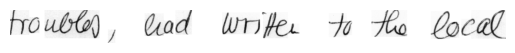

In [147]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio  # Import the v2 version of imageio

img_path = './data/Demo/test2.png'
img = imageio.imread(img_path)  # Read the image from the path
plt.imshow(img, cmap='gray')  # 'cmap' is set to 'gray' since your images are grayscale
plt.axis('off')  # To turn off axis numbering
plt.show()

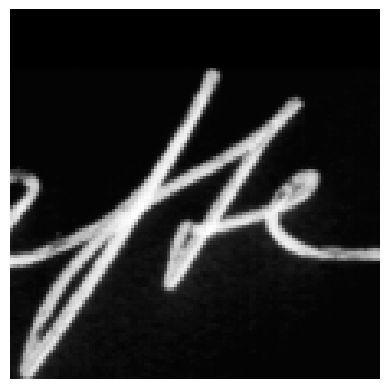

1/1 [==============================] - 0s 23ms/step
The predicted writer is: temp_sentences\p06


In [150]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

def preprocess_image(img_path, height=113, width=113):
    img = Image.open(img_path)
    img = PIL.ImageOps.invert(img)
    image_arr = image_resize(np.array(img, dtype=np.uint8), height=height)  # Resize based on height

    if image_arr.shape[1] > width:  # If width is more than 113 after resizing
        # Center crop to 113 width
        start_col = (image_arr.shape[1] - width) // 2
        image_arr = image_arr[:, start_col:start_col + width]
    elif image_arr.shape[1] < width:  # If width is less than 113 after resizing
        # Pad to 113 width
        pad_amt = width - image_arr.shape[1]
        pad_left = pad_amt // 2
        pad_right = pad_amt - pad_left
        image_arr = np.pad(image_arr, ((0, 0), (pad_left, pad_right)), mode='constant', constant_values=0)

    if image_arr.ndim > 2:
        return None
    image_arr = image_arr / 255.0
    return image_arr

#img_path = './data/Demo/a01-102u-s01-00.png'
#img_path = './data/Demo/a01-003u-s00-00.png'
#img_path = './data/Demo/a01-043u-s00-00.png'
#img_path = './data/Demo/j06-018-s01-00.png' #writer j06
img_path = './data/Demo/test2.png' #writer po6

img_array = preprocess_image(img_path)

# Check if the image was correctly processed
if img_array is not None:
    plt.imshow(img_array, cmap='gray')
    plt.axis('off')
    plt.show()

    img_array = np.expand_dims(img_array, axis=0)  # Model expects a batch of images
    img_array = np.expand_dims(img_array, axis=3)  # Add the channel dimension

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])

    predicted_writer_id = writer_mapping[predicted_class]
    print(f"The predicted writer is: {predicted_writer_id}")
else:
    print("The image could not be processed.")


## Autoencoder

In [153]:
from tensorflow.keras.layers import UpSampling2D

def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)  # adapt this if using `channels_first` image data format

    # Encoding layers
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoding layers
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

autoencoder = build_autoencoder((113, 113, 1))
autoencoder.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 113, 113, 1)]     0         
                                                                 
 conv2d_75 (Conv2D)          (None, 113, 113, 16)      160       
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 57, 57, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_76 (Conv2D)          (None, 57, 57, 8)         1160      
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 29, 29, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_77 (Conv2D)          (None, 29, 29, 8)         584

In [157]:
def preprocess_for_autoencoder(img_array, target_height=116, target_width=116):
    # Resize based on height while keeping aspect ratio
    img_array_resized = image_resize(img_array, height=target_height)

    # If width after resizing is not the desired width
    if img_array_resized.shape[1] != target_width:
        # Center crop or pad to desired width
        if img_array_resized.shape[1] > target_width:
            start_col = (img_array_resized.shape[1] - target_width) // 2
            img_array_resized = img_array_resized[:, start_col:start_col + target_width]
        else:
            pad_amt = target_width - img_array_resized.shape[1]
            pad_left = pad_amt // 2
            pad_right = pad_amt - pad_left
            img_array_resized = np.pad(img_array_resized, ((0, 0), (pad_left, pad_right)), mode='constant', constant_values=0)

    return img_array_resized

X_train_ae = [preprocess_for_autoencoder(x) for x in X_train]
X_test_ae = [preprocess_for_autoencoder(x) for x in X_test]

# Reshape data to feed into the autoencoder
X_train_ae = [x.reshape(116, 116, 1) for x in X_train_ae]
X_test_ae = [x.reshape(116, 116, 1) for x in X_test_ae]

autoencoder.fit(np.array(X_train_ae), np.array(X_train_ae), epochs=50, batch_size=128,
                shuffle=True, validation_data=(np.array(X_test_ae), np.array(X_test_ae)))

Epoch 1/50


ValueError: in user code:

    File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_15" is incompatible with the layer: expected shape=(None, 113, 113, 1), found shape=(None, 116, 116, 1)


In [ ]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[4].output)

### Classifier

In [ ]:
from sklearn.svm import SVC

# Extract features using the encoder
X_train_encoded = encoder.predict(np.array(X_train_ae))
X_test_encoded = encoder.predict(np.array(X_test_ae))

# Flatten the encoded outputs
X_train_encoded_flat = X_train_encoded.reshape(X_train_encoded.shape[0], -1)
X_test_encoded_flat = X_test_encoded.reshape(X_test_encoded.shape[0], -1)

# Train a classifier
clf = SVC()
clf.fit(X_train_encoded_flat, y_train)

# Check accuracy on the test set
accuracy = clf.score(X_test_encoded_flat, y_test)
print("Test accuracy:", accuracy)

### Adding a new class

In [ ]:
# Suppose new_X and new_y are your new images and labels
# new_X_encoded = encoder.predict(new_X)
# new_X_encoded_flat = new_X_encoded.reshape(new_X_encoded.shape[0], -1)

# Append to your training data
# X_train_encoded_flat = np.concatenate((X_train_encoded_flat, new_X_encoded_flat))
# y_train = np.concatenate((y_train, new_y))

# Retrain your classifier
# clf.fit(X_train_encoded_flat, y_train)